In [1]:
from hyper import *
from alignment import *
from datasets.preprecossing import *
from core import *
from datasets.loading import *
from datasets.hc_dataset import *
from datasets.balance_dataset import *
from utils.linkage import *
from model.balancehc import balancehc

from utils.poincare import *
import scib
import shutil

def add_meta(now,meta_list,merge):
    if(int(now.name)<len(meta_list)):
        now.name= now.name +'_'+ meta_list[int(now.name)];
    merge.append(now)
    for i in now.son:
        add_meta(i,meta_list,merge)

In [2]:
cell_path1 = './datas/23/2/BRCA_GSE110686.h5ad'
folder_path1 = './datas/miss/1/'
radius1 = 0
c1 =0
epoches1 =30
cell_path2 = "./datas/23/3/CRC_GSE146771.h5ad" 
folder_path2 = "./datas/miss/2/" 
radius2 = 0
c2 =0
epoches2 = 30
contin = False
resolution=1
method='average'
alignment=1
n_pca=50
meta_col = 'Celltype..minor.lineage.'
mst = False


In [3]:
data_path=folder_path1+'datas.data'
start=1
end=50
label=0
epoches1=10
epoches2=10
model_path=None
model_path2=None
save_path='./', 
mst = False,
rotate = True


In [4]:
np.random.seed(1234)
torch.manual_seed(1234)
x, y_true, similarities = load_data(data_path,start,end,label)
print("{} length:{}".format(data_path,len(y_true)));
dataset = HCDataset(x, y_true, similarities, num_samples=50000)
dataloader = data.DataLoader(dataset, batch_size=32, shuffle=True, pin_memory=True)
model = HypHC(dataset.n_nodes, 2, 5e-2, 5e-2 ,0.999)

model.to("cpu")
Optimizer = getattr(optim, 'RAdam')
optimizer = Optimizer(model.parameters(),0.0005)
train(model,dataloader,optimizer,similarities,epoches1);


./datas/miss/1/datas.data length:10
Generating all pairs superset
	 Epoch 0 | average train loss: 0.961847
Optimization finished.
	 Epoch 1 | average train loss: 0.938805
Optimization finished.
	 Epoch 2 | average train loss: 0.931450
Optimization finished.
	 Epoch 3 | average train loss: 0.931710
Optimization finished.
	 Epoch 4 | average train loss: 0.924435
Optimization finished.
	 Epoch 5 | average train loss: 0.925434
Optimization finished.
	 Epoch 6 | average train loss: 0.927446
Optimization finished.
	 Epoch 7 | average train loss: 0.923079
Optimization finished.
	 Epoch 8 | average train loss: 0.923375
Optimization finished.
	 Epoch 9 | average train loss: 0.924772
Optimization finished.


In [5]:
model.eval()

sim_fn = lambda x, y: torch.sum(x * y, dim=-1)
n=len(x);
leaves_embeddings = model.normalize_embeddings(model.embeddings.weight.data)
leaves_embeddings = project(leaves_embeddings).detach().cpu()
ijs = sl_np_mst_ij(leaves_embeddings,sim_fn)
uf = UnionFind(n)
uf.merge(ijs)

tree = nx.DiGraph()
for i, j in enumerate(uf.tree()[:-1]):
    if(j!=-1):
        tree.add_edge(j, i)

n = len(leaves_embeddings)
embeddings = complete_tree(tree, leaves_embeddings)

/Users/dongjiajie/Desktop/alignment/fyp/hyperalignment/final/utils/mst.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ij = np.empty((n - 1, 2), dtype=np.int)
/Users/dongjiajie/Desktop/alignment/fyp/hyperalignment/final/utils/mst.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current us

In [6]:

nodes1 = [node(name=str(i),son=[]) for i in range(len(uf.tree()))]
for i in range(n):
    nodes1[i].subson=[i];
for i,j in enumerate(uf.tree()):
    if(j!=-1):
        nodes1[j].son.append(nodes1[i])
    nodes1[i].value=torch.tensor(embeddings[i]);
    nodes1[i].hyper=torch.tensor(embeddings[i])
root = nodes1[-1];

In [7]:
def rotate(nodes,embeddings):
    deep_search_tree(root,0,[],root)
    result = []
    distances = []
    for i in nodes:
        if(int(i)>=n):
            if(len(i.subson)==2):
                for j in i.rest(n):
                    result.append([i.subson,j,int(i),1,int(j)])
    for i in nodes[:-1]:
        if(int(i)>=n and len(i.son)>=2):
            for i1 in range(len(i.subson)):
                for i2 in range(i1+1,len(i.subson)):
                    for j in i.rest(n):
                        result.append([[i.subson[i1],i.subson[i2]],j,int(i),0,int(i.f)])
            
    for i in nodes:
        distances.append(i.distance_to_root);
    distances = torch.tensor(distances)

    dataset_test = balance_dataset(similarities,len(result),embeddings,distances,result)
    dataloader = data.DataLoader(dataset_test, batch_size=1, shuffle=False, pin_memory=True)
    model2 = balancehc(nodes1,torch.tensor(embeddings),hyperparamter = 1)
    Optimizer = getattr(optim, 'RAdam')
    optimizer = Optimizer(model2.parameters(),0.0005)
    train2(model2,dataloader,optimizer,epoches2)
    temp = model2.embeddings.weight.data
    after_balance = temp;
    after_balance = project(after_balance)
    after_balance = np.array(after_balance)
    return temp

In [8]:
deep_search_tree(root,0,[],root)
result = []
distances = []
for i in nodes1:
    if(int(i)>=n):
        if(len(i.subson)==2):
            for j in i.rest(n):
                result.append([i.subson,j,int(i),1,int(j)])
for i in nodes1[:-1]:
    if(int(i)>=n and len(i.son)>=2):
        for i1 in range(len(i.subson)):
            for i2 in range(i1+1,len(i.subson)):
                for j in i.rest(n):
                    result.append([[i.subson[i1],i.subson[i2]],j,int(i),0,int(i.f)])
        
for i in nodes1:
    distances.append(i.distance_to_root)

In [9]:
distances = torch.tensor(distances)

dataset_test = balance_dataset(similarities,len(result),embeddings,distances,result)
dataloader = data.DataLoader(dataset_test, batch_size=1, shuffle=False, pin_memory=True)
model2 = balancehc(nodes1,torch.tensor(embeddings),hyperparamter = 1)
Optimizer = getattr(optim, 'RAdam')
optimizer = Optimizer(model2.parameters(),0.0005)
train2(model2,dataloader,optimizer,epoches2)

/Users/dongjiajie/Desktop/alignment/fyp/hyperalignment/final/datasets/balance_dataset.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  temp = np.array(temp)
/Users/dongjiajie/Desktop/alignment/fyp/hyperalignment/final/model/balancehc.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embeddings.weight.data = torch.tensor(embeddings);


	 Epoch 0 | average train loss: 0.432899


/Users/dongjiajie/Desktop/alignment/fyp/hyperalignment/final/model/balancehc.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  origin_distance = hyp_dist(torch.tensor(self.original[i]),torch.tensor(self.original[j]));
/Users/dongjiajie/Desktop/alignment/fyp/hyperalignment/final/model/balancehc.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  origin_distance = hyp_dist(torch.tensor(self.original[int(nodef.son[0])]),torch.tensor(self.original[k])) + hyp_dist(torch.tensor(self.original[int(nodef.son[1])]),torch.tensor(self.original[k]));
/Users/dongjiajie/Desktop/alignment/fyp/hyperalignment/final/model/balancehc.py:92: UserWarning: To copy construct from a tensor, it is recommended 

	 Epoch 1 | average train loss: 0.427190
	 Epoch 2 | average train loss: 0.426610
	 Epoch 3 | average train loss: 0.425221
	 Epoch 4 | average train loss: 0.424997
	 Epoch 5 | average train loss: 0.425391
	 Epoch 6 | average train loss: 0.425161
	 Epoch 7 | average train loss: 0.425146
	 Epoch 8 | average train loss: 0.424127
	 Epoch 9 | average train loss: 0.424486


In [10]:
temp = model2.embeddings.weight.data
after_balance = temp;
# after_balance = model2.normalize_embeddings(torch.tensor(after_balance))

after_balance = project(after_balance)
after_balance = np.array(after_balance)

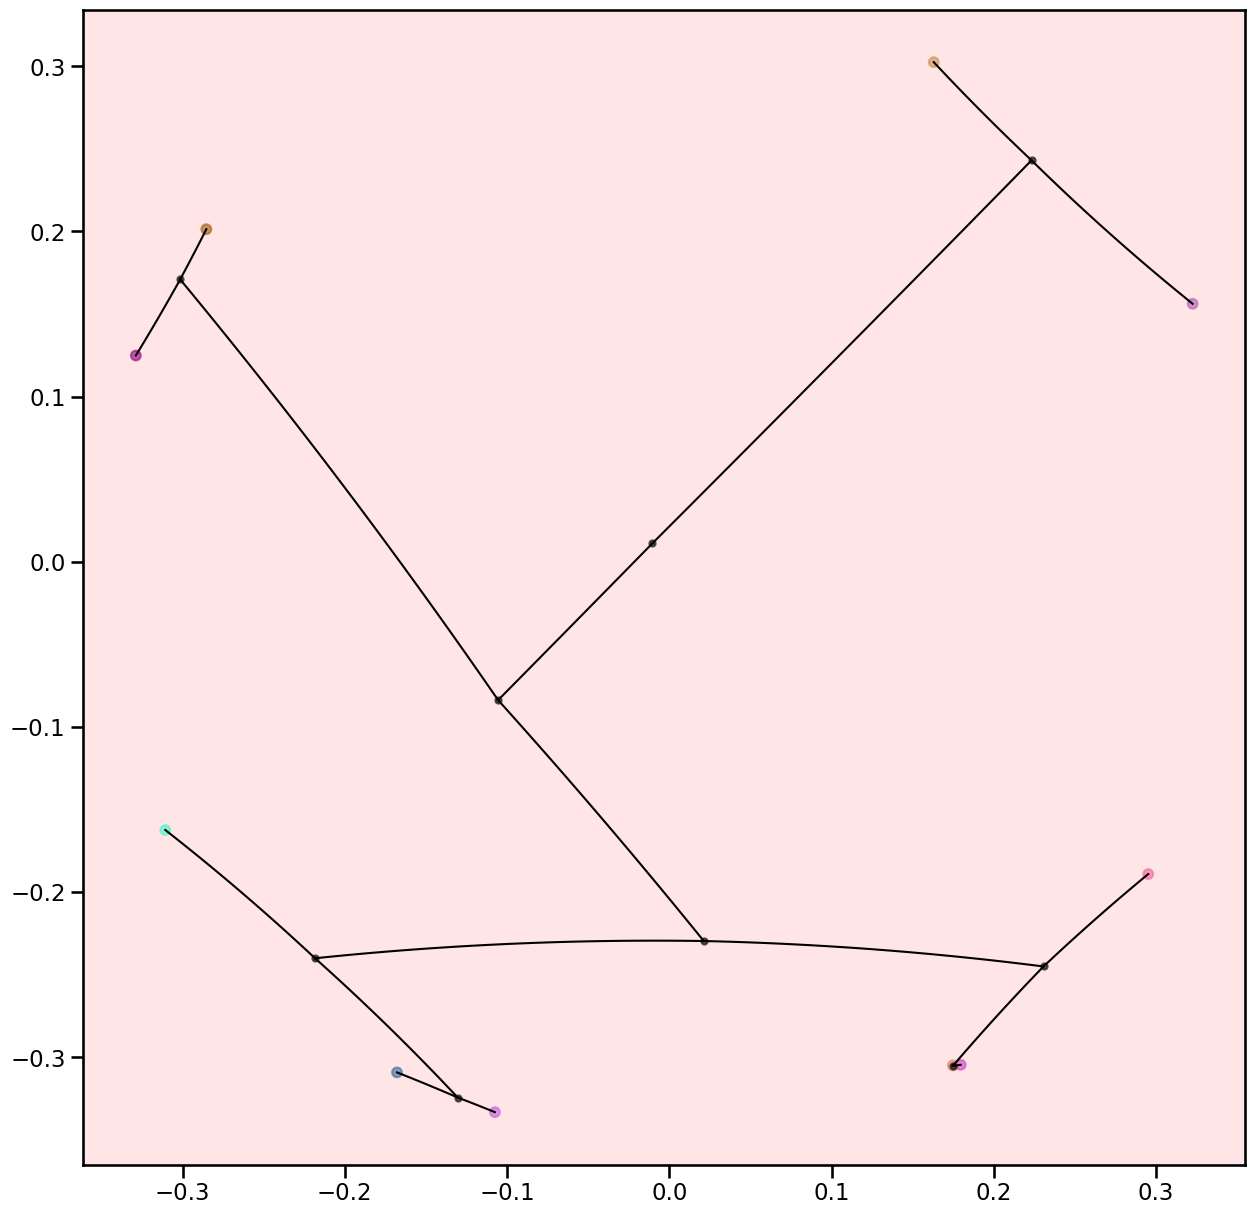

In [11]:
colors = get_colors(y_true, 1234)
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
circle = plt.Circle((0, 0), 1.0, color='r', alpha=0.1)
ax.add_artist(circle)
ax.scatter(after_balance[:n, 0], after_balance[:n, 1], c=colors, s=50, alpha=0.6)
ax.scatter(after_balance[n:,0],after_balance[n:,1],color ='black',s=20,alpha=0.6)
for n1, n2 in tree.edges():
    x1 = after_balance[n1];
    x2 = after_balance[n2];
    plot_geodesic(x1,x2,ax)


In [12]:
root,_ = search_tree(root,0.5,10,10)
show_tree(root).show_fig()

10 1


AttributeError: 'tuple' object has no attribute 'name'

In [ ]:
show_tree(nodes_merge1[0]).show_fig()

In [ ]:
nodes_merge1 = [];
nodes_merge2 = [];
add_meta(root,[],nodes_merge1)
for i in nodes_merge1:
    if(int(i)<n):
        i.subson = [int(i)]
    else:
        i.subson=[]

In [ ]:
deep_search_tree(nodes_merge1[0],0,[],nodes_merge1[0])
result = []
distances = []
for i in nodes_merge1:
    if(int(i)>=n):
        if(int(i.son[0]) <n and int(i.son[1])<n ):
            for i1,j1 in itertools.combinations(i.subson,2):
                for j in i.rest(n):
                    result.append([[i1,j1],j,int(i),1,int(j)])
for i in nodes_merge1[1:]:
    if(int(i)>=n and len(i.son)>=2):
        for i1 in range(len(i.subson)):
            for i2 in range(i1+1,len(i.subson)):
                for j in i.rest(n):
                    result.append([[i.subson[i1],i.subson[i2]],j,int(i),0,int(i.f)])
        
for i in nodes_merge1:
    distances.append(i.distance_to_root);

In [ ]:
distances = torch.tensor(distances)
dataset_test = balance_dataset(similarities,len(result),after_balance,distances,result)
dataloader = data.DataLoader(dataset_test, batch_size=1, shuffle=False, pin_memory=True)
model2 = balancehc(nodes1,torch.tensor(after_balance),hyperparamter = 1)
Optimizer = getattr(optim, 'RAdam')
optimizer = Optimizer(model2.parameters(),0.0005)
train2(model2,dataloader,optimizer,epoches2)

In [ ]:
model2.embeddings.weight.data

In [ ]:
for i,j in zip(after_balance,model2.embeddings.weight.data):
    print(i==np.array(j))
    

In [ ]:
result